### Kalman Filter SIR 

*Why* - Dave Osthu's model required conjugate observation and transition densities in order to use Gibbs sampling. Pomp requires particle fitlering methods. Can we use the analytical properties of the Kalman Filter and use some simple transforms? It seems like we can!


#### Transition Density

$$(S_t',I_t',R_t') \sim MVN(RK4(S_{t-1},I_{t-1},R_{t-1})),\Sigma)$$

Where $RK4$ is the rung-katta approximation to the SIR differential equations

#### Observation Density


$$I_t = \frac{e^{S_t'}}{e^{S_t'} + e^{I_t'} + e^{R_t'}}$$

$$Y_t \sim N(N_t*I_t,\sigma^2)$$

where $N_t$ is the population at time $t$

(100, 3)


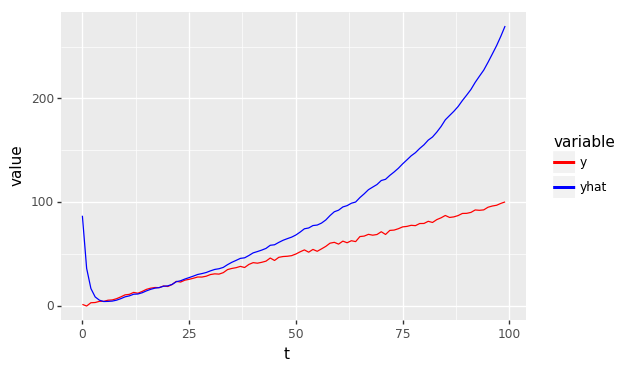

<ggplot: (8737229736341)>

In [59]:
import numpy as np
import pylab as pl
from pykalman import UnscentedKalmanFilter
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt


# initialize parameters
def transition_function(state, noise):
    # Total population, N.
    N = 1000
    # Initial number of infected and recovered individuals, I0 and R0.
    S0, I0, R0 = state[0],state[1], state[2]
    # Everyone else, S0, is susceptible to infection initially.
    # Contact rate, beta, and mean recovery rate, gamma, (in 1/days).
    beta, gamma = 0.2, 1./10 
    # A grid of time points (in days)
    t = np.linspace(0, .001, 2)

    # The SIR model differential equations.
    def deriv(y, t, N, beta, gamma):
        S, I, R = y
        dSdt = -beta * S * I 
        dIdt = beta * S * I  - gamma * I
        dRdt = gamma * I
        return dSdt, dIdt, dRdt

    # Initial conditions vector
    y0 = S0, I0, R0
    # Integrate the SIR equations over the time grid, t.
    ret = odeint(deriv, y0, t, args=(N, beta, gamma))
    S, I, R = ret.T
    S = S[-1] + noise[0]
    I = I[-1] + noise[1]
    R = R[-1] + noise[2]
    ret_ar = np.array([S,I,R]).reshape((-1))
    return ret_ar


def observation_function(state, noise):
    S_ , I_ , R_ = state[0], state[1], state[2]
    I = np.exp(I_)/(np.exp(S_) + np.exp(I_) +np.exp(R_))
    return  1000*I + noise[0]

transition_covariance = np.eye(3)
random_state = np.random.RandomState(0)
observation_covariance = 1#np.eye(3) #+ random_state.randn(3, 3) 
initial_state_mean = [0, 0, 0]
initial_state_covariance = np.eye(3)

# sample from model
kf = UnscentedKalmanFilter(
    transition_function, observation_function,
    transition_covariance, observation_covariance,
    initial_state_mean, initial_state_covariance,
    random_state=random_state
)
#states, observations = kf.sample(100, initial_state_mean)
# estimate state with filtering and smoothing
time_series = np.arange(0,100) + np.random.normal(0,1,100)
filtered_state_estimates = kf.filter(time_series)[0]
smoothed_state_estimates = kf.smooth(time_series)[0]


def states_to_observations(states):
    expected_obs = []
    for state in states:
        S_ , I_ , R_ = state[0], state[1], state[2]
        I = np.exp(I_)/(np.exp(S_) + np.exp(I_) +np.exp(R_))
        expected_obs.append(1000*I)
    return expected_obs


# draw estimates

#lines_true = pl.plot(states_to_observations(filtered_state_estimates), color='b')

from plotnine import *
from plotnine.data import *
import pandas as pd

data = [range(100),time_series.tolist(),states_to_observations(filtered_state_estimates)]
data = np.hstack((np.arange(100).reshape((-1,1)),time_series.reshape((-1,1)),np.array(states_to_observations(filtered_state_estimates)).reshape((-1,1))))
print (data.shape)
df = pd.DataFrame(data, columns=['t','y','yhat'])

df = pd.melt(df, id_vars=['t'], value_vars=['y', 'yhat']) 
p = ggplot(df, aes(x='t', y='value', color='variable'))
(p + geom_line()
   + scale_color_manual(['r', 'b'])
)
